# Fine Foods - Data Overview & Text Analysis
We will be using food reviews from Amazon to build a recommendation engine using Factorization Machine in SAS VIYA

Factorization Machine (FM) is one of the newest algorithms in the Machine Learning space, and has been developed in SAS. FM is a general prediction algorithm, similar to Support Vector Machines, that can model very sparce data, an area where traditional Machine Learning techniques fail. 

Since FM is a general prediction algorithm, it can accept any sized real vector as inputs. Because of this, we will use SAS Viya text analytics capabilities to represent text as numeric vectors, that we can use as inputs to our FM model.


this notebook has **three** parts:
1. Load Data &  Prepare Notebook
2. Data overview & manipulation
3. Perform Text Analytics
4. View & Promote finalized Dataests
5. Perform Analyses

We will use the dataset promoted to public memory to train our FM model in SAS Studio

## 1. Load Data
In this step, we will make a connection to our CAS server, and will load the revelant table that we prepared in Python into memory


In [1]:
from swat import *
import _config
%matplotlib inline
#swat.options.cas.print_messages = False

# Connect to the session
cashost='gtpviyaea12.unx.sas.com'
casport=5570
user,pswd = _config.login()

s = CAS(cashost, casport, user, pswd)

# Create a CAS library called DMLib pointing to the defined directory
## Note, need to specify the srctype is path, otherwise it defaults to HDFS
s.table.addCaslib(datasource={'srctype':'path'}, name='DMlib', path="/viyafiles/ankram/Data");

#Load Data
f = 'foods_prepped1'
s.loadTable(caslib='DMlib', path=f +'.csv', casout=f);

#Load actionsets
actionsets=['fedSQL', 'autoTune', 'factMac', 'textMining']
[s.builtins.loadactionset(i) for i in actionsets];

#Create shortcuts
food = s.CASTable(f)
target = 'score'
#class_inputs = ['helpfulness','productid','time','userid']

NOTE: 'DMlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'DMlib'.
NOTE: Cloud Analytic Services made the file foods_prepped1.csv available as table FOODS_PREPPED1 in caslib DMlib.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'autoTune'.
NOTE: Added action set 'factMac'.
NOTE: Added action set 'textMining'.


## 2. Overview Data & Manipulation
In this step, we will take a look at the data presented to us. We notice that this dataset contains the variables "productId", "userid", and "score". This is the most basic information required to build a recommender system through traditional collaborative filtering methodologies.

While traditional collaborative filtering methods are powerful in their prediction abilities, they are severely restricted by the input vector requirements, typically taking only two inputs - user and item. With factorization machine, we can enrich our models by having a much wider input vector containing more than two inputs. We can see if "Time" and "helpfulness" can make our engine more accurate.

Lastly, each user has some amount of free form text. By using text mining capabilities in Viya, we can summarize the text into topics, which we can then include in our factorization machine model.

Note - We can quickly view the data with the 'head' method 

#Add a column Identifier in-memory
s.dataStep.runCode('''
    data ''' + f + '''; 
        set '''  + f + ''';
        if key<10000;
    run;,
    
    replace="YES"
''')


In [3]:
#Print Number of reviews
print(len(food), "Reviews")

#Validate first few rows
food.head(5)

568454 Reviews


,key,helpfulness,productId,score,summary,text,time,userId
0,248052.0,0/0,B0022N8FEG,5.0,Oh so virital flavorings,We love flavored coffees but the price is just...,1.325290e+09,A3HXLJRBKDH1NC
1,248053.0,1/1,B0048IC0PI,2.0,BEWARE OF BROKEN GLASS!!!,"This ginger is a very high quality, however, i...",1.341274e+09,A137C9LFKPIN52
2,248054.0,0/0,B0047HDOSC,5.0,Dog loves this food!!,My dog cant have chicken and she loves this be...,1.337990e+09,A7C7QG6O3ZHXD
3,248055.0,0/0,B0047HDOSC,5.0,doglover,My dogs love this canned dog food. I feel goo...,1.310429e+09,A1V6KMWCGVOFQJ
4,248056.0,1/2,B001HTP4I6,5.0,Delicious!,I researched many chai tea products before dec...,1.329264e+09,A3HEY6YGBB1CBQ


### Fix Date Field
We will create two character variables to use:
1. Weekday: 1(Sunday) - 7 (Saturday
2. Day_Month: Concatentation of day and month

In [4]:
s.dataStep.runCode('''
    data ''' + f + '''; 
        set '''  + f + ''';
            
            datetm=time + "01jan1970 0:0:0"dt ;
                Format datetm datetime. ;
                   
            date=datepart(datetm);
                format date mmddyy10.;

            weekday=weekday(date);
            
            day_month=substr(put(date, mmddyy10.),1,5);
            
    run;,
    replace="YES"
''')

food.head()

,key,helpfulness,productId,score,summary,text,time,userId,datetm,date,weekday,day_month
0,431472.0,0/0,B006SHM50M,4.0,Very good product,I use to buy Spirulina in Mexico where it is a...,1.342570e+09,A3HGSF94ENICB8,1.658189e+09,19192.0,4.0,07/18
1,431473.0,1/1,B00711SU62,5.0,My poodle loves them!,For some reason my miniature/toy poodle loves ...,1.342397e+09,A1IKOG44PHFNYS,1.658016e+09,19190.0,2.0,07/16
2,431474.0,10/10,B003ZMFUKU,5.0,Fantastic! I LOVE this stuff! (so does my dau...,"My just turned 4 year old daughter will NOT, I...",1.277942e+09,A2FFOEFUUQ0NTW,1.593562e+09,18444.0,5.0,07/01
3,431475.0,10/11,B003ZMFUKU,5.0,My daughter and I both LOVE this!,"My just turned 4 year old daughter will NOT, I...",1.277942e+09,A2FFOEFUUQ0NTW,1.593562e+09,18444.0,5.0,07/01
4,431476.0,4/4,B003ZMFUKU,2.0,organic fruit smoothie,these were smaller than i expected - not even ...,1.295827e+09,ATKAYAD7OC7O1,1.611446e+09,18651.0,2.0,01/24


## 3. Perform Text Analysis
The code below performs text analytics on the free form reviews, generating the following:
1. Creating Document term matrix
2. Creating parent-child relationshipos
3. Text Topics and important terms per topic
4. Creating structured representation of the text data

For this FM model, we will look to reduce the document term matrix into different topics. We will derive both topic membership, and the three structured representations (svd projections), to describe latent differences amoung the free form text data. We will use these numeric vectors, in additional to our original inputs, in our FM model
<br>

We will start out by generating 25 text topics, and will look at the scree plot to try to determine the number of topics

In [5]:
#Load stop list into memory
s.loadTable(caslib='DMlib', path='engstop'+'.sas7bdat', casout='engstop');

#Helper function to aid with text mining
def c_dict(name):
    training_options = dict(name      = name,
                            replace   = True)                           
    return training_options

#Perform Text mining
    #* = optional
s.textMining.tmMine(
  documents=f,
  stopList="engstop",
  docId="key",
  #copyVars=class_inputs + [target],
  text='text',
  reduce=5,
  entities="STD",
  k=25,
  norm="DOC",
  #u=c_dict("svdu"),
  s=c_dict("singular_values"),
  terms=c_dict("terms"), 
  #parent=c_dict("parent"), 
  #child=c_dict("child"), 
  #parseConfig=c_dict("config"), 
  docPro=c_dict("docpro"), 
  topics=c_dict("topics"), 
  topicDecision=True
)

NOTE: Cloud Analytic Services made the file engstop.sas7bdat available as table ENGSTOP in caslib DMlib.


,casLib,Name,Label,Rows,Columns,casTable
0,DMlib,terms,,228711,11,"CASTable('terms', caslib='DMlib')"
1,DMlib,singular_values,,25,2,"CASTable('singular_values', caslib='DMlib')"
2,DMlib,docpro,,568454,51,"CASTable('docpro', caslib='DMlib')"
3,DMlib,topics,,25,7,"CASTable('topics', caslib='DMlib')"


### Determine Topics
After running our model. We must determine an appropriate number of topics that can best represent this free form data. Looking at the scree plot will help us. We do not see much gain after the 5th singular value, so we will choose 5 topics here

Selected Rows from Table SINGULAR_VALUES

   _Id_         _S_
0   1.0  240.276227
1   2.0  128.132056
2   3.0  115.980177
3   4.0  107.946973
4   5.0  100.630672
5   6.0   95.748621
6   7.0   88.197716
7   8.0   84.378282
8   9.0   82.987915
9  10.0   79.239337


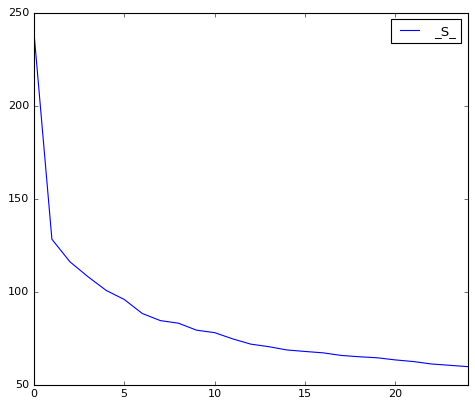

In [7]:
s.CASTable('singular_values')['_S_'].plot(figsize = (7, 6))
print(s.CASTable('singular_values').head(10))

### Re run text mining model
We will re run the model with 5 topics. We will examine the topic membership and the words that make up each topic

In [8]:
#Load stop list into memory
#s.loadTable(caslib='DMlib', path='engstop'+'.sas7bdat', casout='engstop');

#Re Run text mining
s.textMining.tmMine(
  documents=f,
  stopList="engstop",
  docId="key",
  #copyVars=class_inputs + [target],
  text='text',
  reduce=5,
  entities="STD",
  k=5,
  norm="DOC",
  s=c_dict("singular_values"),
  topicDecision=True, 
  docPro=c_dict("docpro"), 
  topics=c_dict("topics"), 
)

#Topic Membership (Binary 1/0 and structured representation)
s.CASTable("docpro").head()

ERROR: The table ENGSTOP already exists in caslib DMlib.
ERROR: The action stopped due to errors.


,key,_Col1_,_Col2_,_Col3_,_Col4_,_Col5_,_TextTopic_1,_TextTopic_2,_TextTopic_3,_TextTopic_4,_TextTopic_5
0,246934.0,0.096819,0.781113,0.252932,0.158751,0.539732,0.0,1.0,0.0,0.0,1.0
1,246935.0,-0.046276,0.841206,0.102739,0.057342,0.525726,0.0,1.0,0.0,0.0,1.0
2,246936.0,-0.105933,0.786057,0.027893,-0.136079,0.592956,0.0,1.0,0.0,0.0,1.0
3,246937.0,0.339582,0.853510,0.045618,0.138785,0.367235,0.0,1.0,0.0,0.0,1.0
4,246938.0,0.142549,0.909876,0.035620,0.094512,0.376304,0.0,1.0,0.0,0.0,1.0


In [9]:
#See topics
s.CASTable("topics").head()

,_TopicId_,_Name_,_Category_,_NumTerms_,_NumDocs_,_TermCutOff_,_DocCutOff_
0,1.0,"+coffee, +tea, +cup, +drink, br",Mult,0.0,122346.0,0.003,0.761
1,2.0,"+dog, +food, +cat, +treat, +dog food",Mult,0.0,105910.0,0.003,0.681
2,3.0,"magnesium, rda, almonds, br, blue",Mult,0.0,74524.0,0.003,0.254
3,4.0,"br, +calorie, +sugar, +add, +taste",Mult,0.0,108671.0,0.003,0.828
4,5.0,"+cat, +food, science diet, diet, +feed",Mult,0.0,84743.0,0.003,0.327


## 4. View Finalized Dataset for analysis

Our data prep is now complete. After doing some data preparation and some text analytics, we now have the following columns to use in our recommendation engine analysis:
1. helpfulness
2. productId
3. weekday
4. day_month,
5. userId
6. _TextTopic_1 - _TextTopic_5
7. Score (Target variable)

Once we are satisfied with our dataset, we can promote the dataset into public memory (making it avaiable to other interfaces and users) or we can save the data to disc.

In [10]:
s.fedSql.execDirect('''
    CREATE TABLE Foods_Prep_Text AS
    SELECT t1.helpfulness,
           t1.productId,
           t1.score,
           t1.summary,
           t1.text,
           t1.time,
           t1.userId,
           t1.weekday,
           t1.day_month,
           t2.*
    FROM foods_prepped1 t1
    INNER JOIN docpro t2
    ON t1.key=t2.key''')

s.CASTable('Foods_Prep_Text').head()

NOTE: Table FOODS_PREP_TEXT was created in caslib DMlib with 568454 rows returned.


,helpfulness,productId,score,summary,text,time,userId,weekday,day_month,key,_Col1_,_Col2_,_Col3_,_Col4_,_Col5_,_TextTopic_1,_TextTopic_2,_TextTopic_3,_TextTopic_4,_TextTopic_5
0,1/1,B003E728CE,1.0,"Be careful, made 1 of my dogs very ill",I must admit these do work for getting your pe...,1.316131e+09,A13H77WHFJF30U,6.0,09/16,134537.0,0.091088,0.917285,0.292268,-0.051900,0.249352,0.0,1.0,1.0,0.0,0.0
1,1/1,B003E728CE,4.0,works for a picky dog,This gets my dog to actually look forward to t...,1.313971e+09,A2U2DUO80R4B6F,2.0,08/22,134538.0,0.041037,0.988941,-0.022880,-0.130338,-0.052921,0.0,1.0,0.0,0.0,0.0
2,1/1,B003E728CE,5.0,Greenies Pill Pockets,Such a wonderful and easy way to give your pet...,1.303776e+09,A3BMSP4XS62M6I,3.0,04/26,134539.0,0.181383,0.980883,-0.012065,0.004968,0.069270,0.0,1.0,0.0,0.0,0.0
3,1/1,B003E728CE,5.0,Fast Delivery,Product was exactly as stated and delivery was...,1.289088e+09,A3A8R62YGYRMTJ,1.0,11/07,134540.0,0.447352,0.621644,0.010336,0.639047,-0.070338,0.0,0.0,0.0,0.0,0.0
4,1/1,B003E728CE,4.0,Amazing little product,"These are the smaller pockets, which I didn't ...",1.276560e+09,A35AHK9W7CB76C,3.0,06/15,134541.0,0.172148,0.894198,0.232573,0.038230,0.339446,0.0,1.0,0.0,0.0,1.0


In [11]:
#Load data into Public memory
#s.table.promote(table='docpro')

#Save file to Server
s.table.save(caslib='DMlib', name='Foods_prep_text_GTP.sashdat', table="Foods_Prep_Text", replace=True)

##Load data into Public memory
#s.loadTable(caslib='DMlib',  path='Foods_prep_text_GTP'+'.sashdat', casout='Foods_Prep_Text')

NOTE: Cloud Analytic Services saved the file Foods_prep_text_GTP.sashdat in caslib DMlib.


[caslib]

 'DMlib'

[name]

 'Foods_prep_text_GTP.sashdat'

+ Elapsed: 19.8s, user: 0.193s, sys: 0.808s, mem: 193mb

In [2]:
s.loadTable(caslib='DMlib',  path='Foods_prep_text_GTP'+'.sashdat', casout='Foods_Prep_Text1')
s.CASTable('Foods_Prep_Text1').head()

NOTE: Cloud Analytic Services made the file Foods_prep_text_GTP.sashdat available as table FOODS_PREP_TEXT1 in caslib DMlib.


,helpfulness,productId,score,summary,text,time,userId,weekday,day_month,key,_Col1_,_Col2_,_Col3_,_Col4_,_Col5_,_TextTopic_1,_TextTopic_2,_TextTopic_3,_TextTopic_4,_TextTopic_5
0,0/0,B004QDA8WC,2.0,WAY too SWEET for me!,As someone who really enjoys a Chai Tea Latte ...,1.350605e+09,A19SQLKMY7PEEI,6.0,10/19,463584.0,0.841102,0.139877,0.059419,0.495123,0.155901,1.0,0.0,0.0,0.0,0.0
1,0/0,B004QDA8WC,3.0,Great change from coffee,Got this as a present for my son for our Keuri...,1.350605e+09,A10O4LYO967IZ,6.0,10/19,463585.0,0.719527,0.372908,0.051278,0.573038,0.110539,0.0,0.0,0.0,0.0,0.0
2,0/0,B004QDA8WC,3.0,Not a bad chai latte but expensive,If I could I'd give it 3.5 stars.<br /><br />T...,1.350259e+09,A1PATZ96CQ5X7K,2.0,10/15,463586.0,0.690319,0.092326,0.154206,0.665715,0.219043,0.0,0.0,0.0,0.0,0.0
3,0/0,B004QDA8WC,5.0,Comfort in a cup,"This Chai Latte is a ""go to"" when you want a l...",1.350173e+09,ALEABNMSVO1JI,1.0,10/14,463587.0,0.615672,0.269603,0.072997,0.664087,0.319254,0.0,0.0,0.0,0.0,0.0
4,0/0,B004QDA8WC,1.0,Not a fan,I'm particular when it comes to chai tea but I...,1.350000e+09,A25L6BAHYZH652,6.0,10/12,463588.0,0.973065,-0.105761,0.019914,0.088694,0.183566,1.0,0.0,0.0,0.0,0.0


## V. Perform Anaysis

We will perform three different factorization machines to predict score:
1. score = userID + productId
2. score = userID + productId + helpfulness + weekday + day_month
3. score = userID + productId + helpfulness + weekday + day_month + _TextTopic_1-_TextTopic_5

In [6]:
s.loadactionset('autotune')

class_inputs = ['userId', 'productId']

training_options = dict(
                    table     = 'Foods_Prep_Text1',
                    inputs    = class_inputs,
                    nominals  = class_inputs,
                    target    = target,
                    seed      = 123,
                    savestate = dict(name = 'fm_model_short', replace = True))

s.invoke('autotune.tuneFactMac', trainOptions=training_options,
                                           tunerOptions=dict(maxTime=300, validationPartitionFraction=0.1),
                                           tuningParameters=[dict(namePath='nfactors', initValue=2)])
for response in s:
    for k, v in response:
        print(k, v)

NOTE: Added action set 'autotune'.
NOTE: Autotune is started for 'Factorization Machine' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=300 (sec.).
NOTE: Autotune objective is 'Root Average Squared Error'.
NOTE: Autotune number of parallel evaluations is set to 1, each using 3 worker nodes.
NOTE: The INITVALUE '2' of tuning parameter NFACTORS is not included in the VALUELIST for this parameter.
NOTE: The initial point will not be used to seed the tuning process.
NOTE: The seed for random partition/fold generation is 123.
         Iteration       Evals     Best Objective        Time
                 0           1             1.1066        7.14
                 1           9              1.038      392.15
NOTE: Autotune process reached maximum tuning time.
NOTE: Using SEED=123.
NOTE: Beginning data reading and levelization...
NOTE: Data reading and levelization complete.
NOTE: Beginning optimization of the factorization ma

In [8]:
s.loadactionset('autotune')

class_inputs = ['userId', 'productId','helpfulness', 'time']#,'weekday','day_month']

training_options = dict(
                    table     = 'Foods_Prep_Text1',
                    inputs    = class_inputs,
                    nominals  = class_inputs,
                    target    = target,
                    seed      = 123,
                    savestate = dict(name = 'fm_model_short', replace = True))

s.invoke('autotune.tuneFactMac', trainOptions=training_options,
                                           tunerOptions=dict(maxTime=300, validationPartitionFraction=0.1),
                                           tuningParameters=[dict(namePath='nfactors', initValue=2)])

for response in s:
    for k, v in response:
        print(k, v)

NOTE: Added action set 'autotune'.
NOTE: Autotune is started for 'Factorization Machine' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=300 (sec.).
NOTE: Autotune objective is 'Root Average Squared Error'.
NOTE: Autotune number of parallel evaluations is set to 1, each using 3 worker nodes.
NOTE: The INITVALUE '2' of tuning parameter NFACTORS is not included in the VALUELIST for this parameter.
NOTE: The initial point will not be used to seed the tuning process.
NOTE: The seed for random partition/fold generation is 123.
         Iteration       Evals     Best Objective        Time
                 0           1             1.1947        7.38
NOTE: Using SEED=123.
NOTE: Beginning data reading and levelization...
NOTE: Data reading and levelization complete.
NOTE: Beginning optimization of the factorization machine model...
NOTE: >>> Progress: completed iteration 1
NOTE: >>> Progress: completed iteration 2
NOTE: >>> Progr

ERROR: The optimization has encountered numerical problems. Consider reducing the LEARNSTEP= parameter and/or standardizing the target variable.
ERROR: The optimization did not converge.
ERROR: The action stopped due to errors.


                 1           6                  0      311.85
NOTE: Autotune process reached maximum tuning time.
NOTE: Using SEED=123.
NOTE: Beginning data reading and levelization...
NOTE: Data reading and levelization complete.
NOTE: Beginning optimization of the factorization machine model...
NOTE: >>> Progress: completed iteration 1
NOTE: >>> Progress: completed iteration 2
NOTE: >>> Progress: completed iteration 3
NOTE: >>> Progress: completed iteration 4
NOTE: >>> Progress: completed iteration 5
NOTE: >>> Progress: completed iteration 6
NOTE: >>> Progress: completed iteration 7
NOTE: >>> Progress: completed iteration 8
NOTE: >>> Progress: completed iteration 9
NOTE: >>> Progress: completed iteration 10
NOTE: >>> Progress: completed iteration 11
NOTE: >>> Progress: completed iteration 12
NOTE: >>> Progress: completed iteration 13
NOTE: >>> Progress: completed iteration 14
NOTE: >>> Progress: completed iteration 15
NOTE: >>> Progress: completed iteration 16
NOTE: >>> Progress: com

FitStat Fit Statistics for _AUTOTUNE_DEFAULT_SCORE_TABLE_

      NOBS       ASE      DIV     RASE       MAE      RMAE      MSLE     RMSLE
0  37219.0  1.083077  37219.0  1.04071  0.570754  0.755482  0.076263  0.276158
TunerInfo Tuner Information

                         Parameter                       Value
0                       Model Type       Factorization Machine
1         Tuner Objective Function  Root Average Squared Error
2                    Search Method                          GA
3              Maximum Evaluations                          50
4                  Population Size                          10
5               Maximum Iterations                           5
6   Maximum Tuning Time in Seconds                         300
7                  Validation Type            Single Partition
8    Validation Partition Fraction                        0.10
9                        Log Level                           2
10                            Seed                         12

In [10]:
s.loadactionset('autotune')

class_inputs = ['userId', 'productId','helpfulness', 'day_month']#'weekday','day_month', '_Col1',
                           #'_Col2','_Col3','_Col4','_Col5_']

training_options = dict(
                    table     = 'Foods_Prep_Text1',
                    inputs    = class_inputs,
                    nominals  = class_inputs,
                    target    = target,
                    seed      = 123,
                    savestate = dict(name = 'fm_model_short', replace = True))

s.invoke('autotune.tuneFactMac', trainOptions=training_options,
                                           tunerOptions=dict(maxTime=600, validationPartitionFraction=0.1),
                                           tuningParameters=[dict(namePath='nfactors', initValue=2)])

for response in s:
    for k, v in response:
        print(k, v)

NOTE: Added action set 'autotune'.
NOTE: Autotune is started for 'Factorization Machine' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=600 (sec.).
NOTE: Autotune objective is 'Root Average Squared Error'.
NOTE: Autotune number of parallel evaluations is set to 1, each using 3 worker nodes.
NOTE: The INITVALUE '2' of tuning parameter NFACTORS is not included in the VALUELIST for this parameter.
NOTE: The initial point will not be used to seed the tuning process.
NOTE: The seed for random partition/fold generation is 123.
         Iteration       Evals     Best Objective        Time
                 0           1             1.1643        7.23
NOTE: Using SEED=123.
NOTE: Beginning data reading and levelization...
NOTE: Data reading and levelization complete.
NOTE: Beginning optimization of the factorization machine model...
NOTE: >>> Progress: completed iteration 1
NOTE: >>> Progress: completed iteration 2
NOTE: >>> Progr

ERROR: The optimization has encountered numerical problems. Consider reducing the LEARNSTEP= parameter and/or standardizing the target variable.
ERROR: The optimization did not converge.
ERROR: The action stopped due to errors.
ERROR: The optimization has encountered numerical problems. Consider reducing the LEARNSTEP= parameter and/or standardizing the target variable.
ERROR: The optimization did not converge.
ERROR: The action stopped due to errors.


                 2          12                  0      619.36
NOTE: Autotune process reached maximum tuning time.
NOTE: Using SEED=123.
NOTE: Beginning data reading and levelization...
NOTE: Data reading and levelization complete.
NOTE: Beginning optimization of the factorization machine model...
NOTE: >>> Progress: completed iteration 1
NOTE: >>> Progress: completed iteration 2
NOTE: >>> Progress: completed iteration 3
NOTE: >>> Progress: completed iteration 4
NOTE: >>> Progress: completed iteration 5
NOTE: >>> Progress: completed iteration 6
NOTE: >>> Progress: completed iteration 7
NOTE: >>> Progress: completed iteration 8
NOTE: >>> Progress: completed iteration 9
NOTE: >>> Progress: completed iteration 10
NOTE: >>> Progress: completed iteration 11
NOTE: >>> Progress: completed iteration 12
NOTE: >>> Progress: completed iteration 13
NOTE: >>> Progress: completed iteration 14
NOTE: >>> Progress: completed iteration 15
NOTE: >>> Progress: completed iteration 16
NOTE: >>> Progress: com

FitStat Fit Statistics for _AUTOTUNE_DEFAULT_SCORE_TABLE_

      NOBS       ASE      DIV     RASE      MAE      RMAE      MSLE    RMSLE
0  37222.0  0.996843  37222.0  0.99842  0.54606  0.738959  0.074087  0.27219
TunerInfo Tuner Information

                         Parameter                       Value
0                       Model Type       Factorization Machine
1         Tuner Objective Function  Root Average Squared Error
2                    Search Method                          GA
3              Maximum Evaluations                          50
4                  Population Size                          10
5               Maximum Iterations                           5
6   Maximum Tuning Time in Seconds                         600
7                  Validation Type            Single Partition
8    Validation Partition Fraction                        0.10
9                        Log Level                           2
10                            Seed                         123
Tu

In [14]:
s.close()